In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image, ImageDraw
import cv2
import numpy as np
import matplotlib.colors as mc
from copy import deepcopy
import imageio
from tqdm import tqdm
import os
import torch
import torchvision
import itertools

In [3]:
from package.utils.log import tqdm_iterator
from package.utils.visualize import show_grid_of_images

In [4]:
def get_empty_image(bg="black"):
    if bg == "white":
        image = Image.fromarray(255 * np.ones((H, W, 3), dtype=np.uint8))
    elif bg == "black":
        image = Image.fromarray(np.zeros((H, W, 3), dtype=np.uint8))
    else:
        raise NotImplementedError
    return image


def process_color(color, alpha):

    assert alpha <= 1. and alpha >= 0. and isinstance(alpha, float)
    alpha = int(255 * alpha)

    if isinstance(color, str):
        color = mc.to_rgb(color)
        color = list(color)
        color = [int(255 * x) for x in color]   
        # color will be RGB, need to pass alpha into the 4th channel
        color += [alpha]
        color = tuple(color)
    else:
        color = list(color)
        if len(color) == 3:
            color += [alpha]
        color = tuple(color)

    return alpha, color


def save_gif(images, path):
    images = [np.asarray(image) for image in images]
    imageio.mimsave(path, images)


def draw_circle_on_image(image, center, radius, color=(255,0,0,0), alpha=1.):
    image = deepcopy(image)
    draw = ImageDraw.Draw(image, "RGBA")
    x, y = center
    r = radius

    alpha, color = process_color(color, alpha)
    
    draw.ellipse((x-r, y-r, x+r, y+r), fill=color)
    return image

    
def draw_square_on_image(image, center, side, color=(255,0,0,0), alpha=1.):
    image = deepcopy(image)
    draw = ImageDraw.Draw(image, "RGBA")
    
    x0, y0 = int(center[0] - side // 2), int(center[1] - side // 2)
    x1, y1 = int(center[0] + side // 2), int(center[1] + side // 2)
    xy = [(x0, y0), (x1, y1)]

    alpha, color = process_color(color, alpha)

    draw.rectangle(xy=xy, fill=color)
    return image


def draw_triangle_on_image(image, center, side, color=(255,0,0,0), alpha=1.):
    image = deepcopy(image)
    draw = ImageDraw.Draw(image, "RGBA")

    alpha, color = process_color(color, alpha)
    
    x, y = center
    s = side
    sides = [
        (x - s/2., y + s / (2. * np.sqrt(3))),
        (x, y - s / np.sqrt(3)),
        (x + s/2., y + s / (2. * np.sqrt(3))),
    ]
    draw.polygon(sides, fill=color)
    return image

In [5]:
left_alpha_sequence = np.linspace(0, 1, 15)
right_alpha_sequence = np.linspace(0, 1, 15)
H, W = 224, 224


left_shape = {
    "name": "triangle",
    "common_args": {"side": 100},
}
right_shape = {
    "name": "circle",
    "common_args": {"radius": 50},
}

images = []

left_top = (W / 4, H / 4)
left_radius = 50
left_color = "red"
left_generator_function = eval(f"draw_{left_shape['name']}_on_image")
left_position = left_top


right_bottom = (3 * W / 4, 3 * H / 4)
right_radius = 50
right_color = "yellow"
right_generator_function = eval(f"draw_{right_shape['name']}_on_image")
right_position = right_bottom

for alpha in left_alpha_sequence:
    image = get_empty_image(bg="black")
    image = left_generator_function(
        image=image, center=left_position, color=left_color, alpha=alpha, **left_shape["common_args"],
    )
    # image = draw_circle_on_image(image, right_bottom, right_radius, right_color, alpha=0.)
    images.append(image)
    
for alpha in right_alpha_sequence:
    image = get_empty_image(bg="black")
    # image = draw_circle_on_image(image, left_top, left_radius, left_color, alpha=1.)
    # image = draw_circle_on_image(image, right_bottom, right_radius, right_color, alpha=alpha)
    image = right_generator_function(
        image=image, center=right_position, color=right_color, alpha=alpha, **right_shape["common_args"],
    )
    images.append(image)

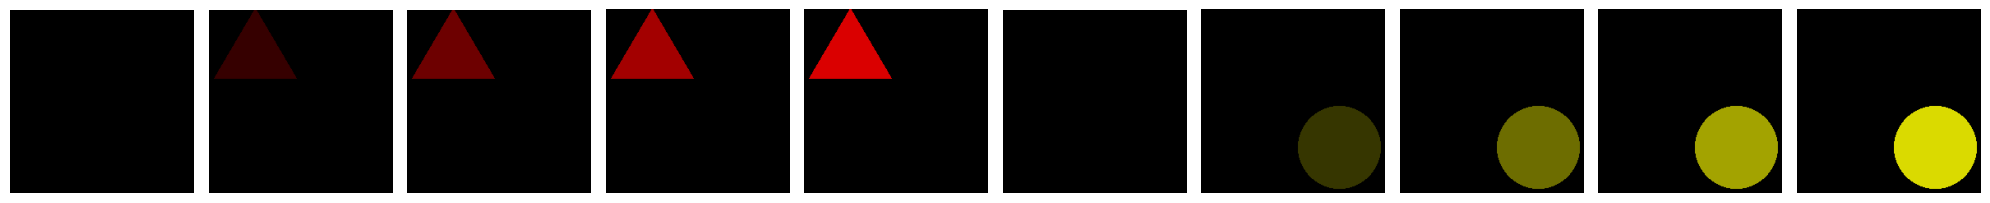

In [6]:
show_grid_of_images(images[::3], n_cols=10, figsize=(20, 3))